In [1]:
%matplotlib inline
import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
from google.colab import files

uploaded = files.upload()

Saving world_cup_top_goal_scorers .csv to world_cup_top_goal_scorers .csv


In [2]:
import pandas as pd
import io

top_goals = pd.read_csv(io.BytesIO(uploaded['world_cup_top_goal_scorers .csv']))
print(top_goals.head())

   Year          Player(s)  Number of goals
0  1930  Guillermo Stábile                8
1  1934    Oldřich Nejedlý                5
2  1938           Leônidas                7
3  1950             Ademir                8
4  1954      Sándor Kocsis               11


In [3]:
mean_goals = top_goals['Number of goals'].mean()
stdev_goals = top_goals['Number of goals'].std(ddof=0)

print("Mean number of goals is {:.2f}".format(mean_goals))
print("Standard deviation is {:.2f}".format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


In [4]:
#Calculating z score from scipy stats
zscore_goals = ss.zscore(top_goals['Number of goals'], ddof=0, nan_policy='omit') # nan_policy omits any nan values and keeps all numbers
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(8)    

,Year,Player(s),Number of goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647


In [9]:
def plot_anomaly(score_data, threshold):

    # Mask to plot values above and below the threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1,  len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)

    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold, color='r', label='threshold', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player rank')
    plt.ylabel('Z-score')
    plt.show()  

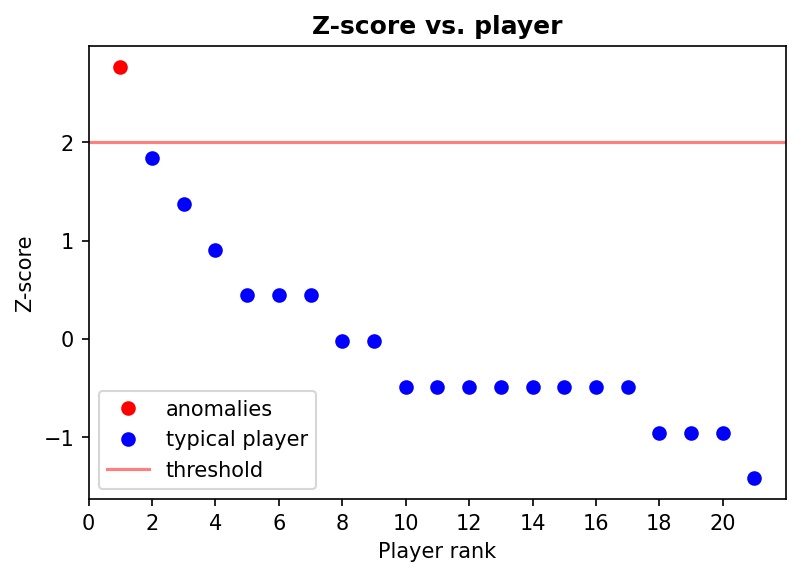

In [10]:
plot_anomaly(top_goals['zscore'], 2)

In [11]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Number of goals,zscore
5,1958,Just Fontaine,13,2.770264


In [13]:
# since if there comes an anomaly in the data, the mean will change drastically, and hence, the z score will change, too
# so for that to be unchanged, we use the median approach which will not change even if we change one data in the dataset

In [14]:
median_goals = np.median(top_goals['Number of goals'])
median_goals

6.0

In [29]:
def modified_zscore(data, consistency_correction=1.4826):
    median = np.median(data)
    print(median)
    deviation_from_median = np.array(data) - median
    print(deviation_from_median)
    mad = np.median(np.abs(deviation_from_median)) # mad is the median of the absolute deviations which is 1
    print(np.abs(deviation_from_median))
    mod_zscore = deviation_from_median/(consistency_correction*mad)
    return mod_zscore, mad

In [30]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Number of goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)
#top_goals

6.0
[ 2. -1.  1.  2.  5.  7. -2.  3.  4.  1.  0.  0.  0.  0.  0.  0.  2. -1.
 -1.  0.  0.]
[2. 1. 1. 2. 5. 7. 2. 3. 4. 1. 0. 0. 0. 0. 0. 0. 2. 1. 1. 0. 0.]


In [18]:
print(mad_goals)

1.0


In [19]:
def plot_anomaly_based_on_median(score_data, threshold):

    # Mask to plot values above and below the threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1,  len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)

    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold, color='r', label='threshold', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Modified Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified Z-score')
    plt.show()  

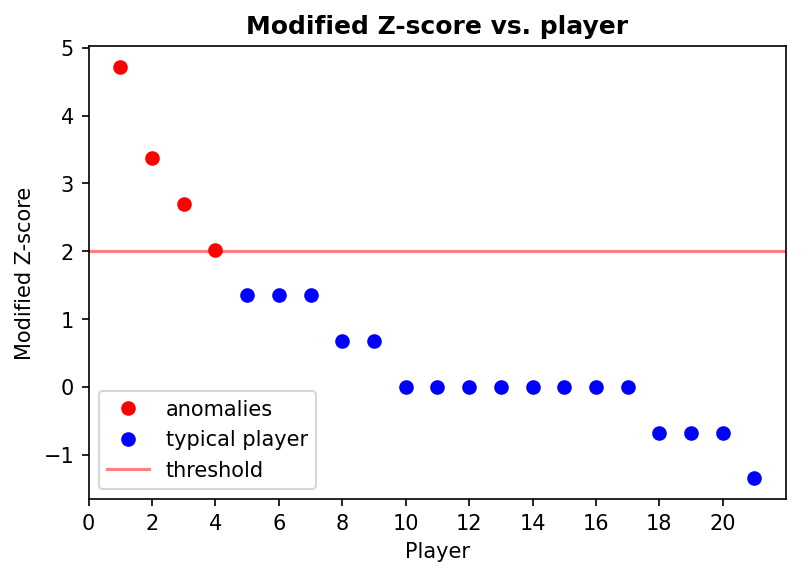

In [20]:
plot_anomaly_based_on_median(top_goals['mod_zscore'], 2)

In [21]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Number of goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


In [22]:
# The median approach gives us the anomalies with respect to the middle value of the zscore, and this won't change regardless of anomalies, and will give anomalies if we add them